
# Automatic Gain Control
Automatic Gain Control is an algorithm, which scales the input of a given sensor signal to a target level. This is important, because of the different sensitivities of different microphones. The user don't want to shout as loud as possible into an microphone, only because it is less sensitive than normal microphones.

In the following a sample $x(n)$ is scaled to zero mean and a given level $L$ in dB FS by the following formulas:

$y(n) = x(n) - a$

$z(n) = b\cdot y(n)$

with

$a = \frac{1}{N}\sum_{n=0}^{N-1} x(n)$

and

$b = \sqrt{\frac{N\cdot A^2}{2}\frac{10^{L/10}}{\sum_{n=0}^{N-1}y^2(n)}}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

A = 2 # maximum magnitude of a typical sound signal after AD-conversion
x = (np.random.rand(1000) * 2 - 1) * 0.3 # 0.3 corresponds to the real gain of the signal, which must be smaller than A
Level = 10*np.log10(2*np.mean(x**2) / (A**2))
print('Level before applying the automatic Gain Control: ', Level, ' dB')

Level before applying the automatic Gain Control:  -18.499075444633746  dB


In [3]:
TargetLevel = -30
N = x.shape[0]
a = np.mean(x)
y = x - a
b = np.sqrt((N*A*A/2*10**(TargetLevel / 10))/np.sum(y**2))
z = b * y

Level = 10*np.log10(2*np.mean(z**2) / (A**2))
print('Level after applying the automatic Gain Control: ', Level, ' dB')

Level after applying the automatic Gain Control:  -30.0  dB


In order to avoid the intermediate step of evaluating the parameter $y(n)$ the parameter $b$ can be described by:

$b = \sqrt{\frac{A^2}{2}\frac{10^{L/10}}{\frac{1}{N}\sum_{n=0}^{N-1}\left(x(n) - a\right)^2}}$

$\rightarrow b = \sqrt{\frac{A^2}{2}\frac{10^{L/10}}{\frac{1}{N}\left(\sum_{n=0}^{N-1}x^2(n) - 2a\sum_{n=0}^{N-1} x(n) + \sum_{n=0}^{N-1}a^2\right)}}$

$\rightarrow b = \sqrt{\frac{A^2}{2}\frac{10^{L/10}}{\frac{1}{N}\left(\sum_{n=0}^{N-1}x^2(n) - 2aNa + N\cdot a^2\right)}}$

$\rightarrow b = \sqrt{\frac{A^2}{2}\frac{10^{L/10}}{\frac{1}{N}\sum_{n=0}^{N-1}x^2(n) - 2a^2 + a^2}}$

$\rightarrow b = \sqrt{\frac{A^2}{2}\frac{10^{L/10}}{\frac{1}{N}\sum_{n=0}^{N-1}x^2(n) - a^2}}$

In [4]:
x_mean = np.mean(x)
x_power = np.mean(x**2)

a = x_mean
b = np.sqrt(A*A/2*(10**(TargetLevel / 10))/(x_power - x_mean**2))
z = b * (x - a)

Level = 10*np.log10(2*np.mean(z**2) / (A**2))
print('Level after applying the automatic Gain Control in one step: ', Level, ' dB')

Level after applying the automatic Gain Control in one step:  -30.0  dB


In an online-algorithm not all samples of the input stream $x(n)$ are known. Instead, only the samples in the past are known. In such scenarios, the mean and the variance is measured continuously. From these both parameters, the necessary parameters $a$ and $b$ can be derived as shown above.

In the following example, we assume that blocks of $10$ ms length are analysed. With each new block, the mean and the variance are updated by a simple IIR filter:

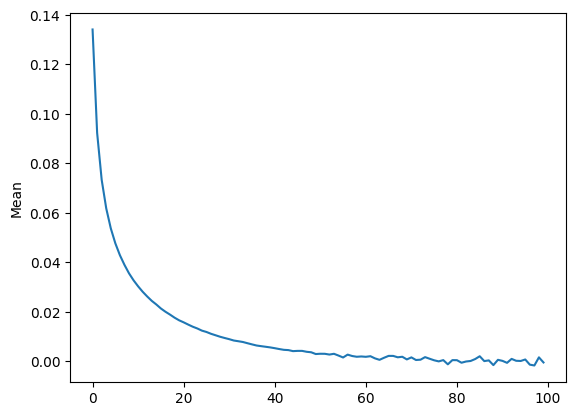

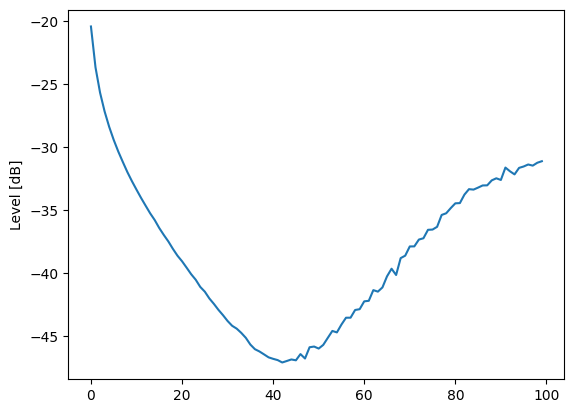

In [5]:
SamplingFrequency = 48000
BlockLengthInMilliseconds = 10
BlockLengthInSamples = int(BlockLengthInMilliseconds * SamplingFrequency / 1000)

c = 0.9
x = np.random.randn(SamplingFrequency)*1 + 100 # 0.3 corresponds to a measurement offset
x_mean = 0.0
x_power = 0.0
NumberOfBlocks = int(x.shape[0] / BlockLengthInSamples)
Level = np.zeros((NumberOfBlocks))
Mean = np.zeros((NumberOfBlocks))
for n in range(NumberOfBlocks):
    idx1 = n * BlockLengthInSamples
    idx2 = idx1 + BlockLengthInSamples
    x_Block = x[idx1:idx2]
    x_mean     = c * x_mean     + (1-c) * np.mean(x_Block)
    x_power = c * x_power + (1-c) * np.mean(x_Block**2)
    a = x_mean
    b = np.sqrt(A*A/2*(10**(TargetLevel / 10))/(x_power - x_mean**2))
    z_Block = b * (x_Block - a)
    Level[n] = 10*np.log10(2*np.mean(z_Block**2) / (A**2))
    Mean[n] = np.mean(z_Block)

plt.plot(Mean)
plt.ylabel('Mean')
plt.show()
plt.plot(Level)
plt.ylabel('Level [dB]')
plt.show()

## Programming exercise:

Beside the above mentioned normalization to zero mean and a given level in dB FS, two other normalization strategies are commonly used:

1) UniformNormalization leads to a scaling to the interval from 0..1.

2) GaussianNormalization leads to a zero mean and a standard deviation of 1.

Implement both functions for normalization.

Additionally, you should implement the pearson correlation:

$\varphi\left(x, y\right)=\frac{\sum_n \left(x(n)-\mu_x\right)\cdot \left(y(n)-\mu_y\right)}{\sqrt{\sum_n \left(x(n)-\mu_x\right)^2}\cdot\sqrt{\sum_n \left(y(n)-\mu_y\right)^2}}$

with $\mu_x$ as the mean of $x$ and $\mu_y$ as the mean of $y$.


In [5]:
import unittest

def PearsonCorrelation(x, y):
    phi = 0
    ### solution
    x_zeromean = x - np.mean(x)
    y_zeromean = y - np.mean(y)
    phi = np.sum(x_zeromean * y_zeromean) / np.sqrt(np.sum(x_zeromean**2) * np.sum(y_zeromean**2))
    ### solution
    return phi

def UniformNormalization(x):
    y = x
    ### solution
    max = np.amax(x)
    min = np.amin(x)
    y = (x - min) / (max - min)
    ### solution
    return y

def GaussianNormalization(x):
    y = x
    ### solution
    x_zeromean = x - np.mean(x)
    y = x_zeromean / np.sqrt(np.mean(x_zeromean**2))
    ### solution
    return y

x = np.random.randn(1000)

def PearsonRankCorrelation(x, y):
    return PearsonCorrelation(np.argsort(x), np.argsort(y))

class TestProgrammingExercise(unittest.TestCase):

    def test_PearsonCorrelation(self):
        y = 3*x
        self.assertGreater(PearsonCorrelation(x, y), 0.999)

    def test_PearsonCorrelation2(self):
        y = np.random.randn(x.shape[0])
        self.assertLess(np.abs(PearsonCorrelation(x, y)), 0.1)

    def test_PearsonRankCorrelation(self):
        y = x**3
        self.assertGreater(PearsonRankCorrelation(x, y), 0.999)
        
    def test_UniformNormalizationMinimum(self):
        y = UniformNormalization(x)
        self.assertGreaterEqual(np.amin(y), 0.0)

    def test_UniformNormalizationMaximum(self):
        y = UniformNormalization(x)
        self.assertLessEqual(np.amax(y), 1.0)    

    def test_UniformNormalizationOrder(self):
        y = UniformNormalization(x)
        self.assertGreater(PearsonRankCorrelation(x, y), 0.999)

    def test_GaussianNormalizationMean(self):
        y = GaussianNormalization(x)
        self.assertAlmostEqual(np.mean(y), 0.0, delta = 1e-6)

    def test_GaussianNormalizationStd(self):
        y = GaussianNormalization(x)
        self.assertAlmostEqual(np.std(y), 1.0, delta = 1e-6)    

    def test_GaussianNormalizationOrder(self):       
        y = GaussianNormalization(x)   
        self.assertGreater(PearsonRankCorrelation(x, y), 0.999)
    
# https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
unittest.main(argv=[''], verbosity=2, exit=False)

test_GaussianNormalizationMean (__main__.TestProgrammingExercise.test_GaussianNormalizationMean) ... ok
test_GaussianNormalizationOrder (__main__.TestProgrammingExercise.test_GaussianNormalizationOrder) ... ok
test_GaussianNormalizationStd (__main__.TestProgrammingExercise.test_GaussianNormalizationStd) ... ok
test_PearsonCorrelation (__main__.TestProgrammingExercise.test_PearsonCorrelation) ... ok
test_PearsonCorrelation2 (__main__.TestProgrammingExercise.test_PearsonCorrelation2) ... ok
test_PearsonRankCorrelation (__main__.TestProgrammingExercise.test_PearsonRankCorrelation) ... ok
test_UniformNormalizationMaximum (__main__.TestProgrammingExercise.test_UniformNormalizationMaximum) ... ok
test_UniformNormalizationMinimum (__main__.TestProgrammingExercise.test_UniformNormalizationMinimum) ... ok
test_UniformNormalizationOrder (__main__.TestProgrammingExercise.test_UniformNormalizationOrder) ... ok

----------------------------------------------------------------------
Ran 9 tests in 0

## Exam preparation

1) Evaluate the parameters $a$ and $b$ such that $z[n] = (x[n] - a) \cdot b$ has zero mean and unit variance.

2) Show, that the Pearson correlation is symmetric: $\varphi\left(x,y\right)=\varphi\left(y,x\right)$

3) Evaluate, under which condition for $a$ with $a\in\mathbb{R}$ the Pearson correlation is scale invariant: $\varphi\left(x,y\right)=\varphi\left(x, a\cdot y\right)$

4) The output of a highpass $H(z) = \frac{z-1}{z-0.999}$ is $s(n)$. Evaluate all poles and zeros from $H(z)$. An Automatic Gain Control should be applied to $s(n)$ such that $g(n)$ has zero mean: $g(n)=s(n)-b$. Evaluate $b$.